In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('../data/final_model_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Loaded data with shape: {df.shape}")
print("\nColumns available:", ', '.join(df.columns))


Loaded data with shape: (3762, 18)

Columns available: Date, Open, High, Low, Close, Volume, Dividends, Stock splits, Ticker, EMA10, EMA50, RSI, MACD, MACD_Signal, MACD_Hist, future_return, Signal, y


C:\Users\techs\AppData\Local\Temp\ipykernel_47344\1141526603.py:20: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [2]:
# Define feature sets and prepare data
feature_columns = [
    # Technical Indicators
    'RSI',
    'EMA10',
    'EMA50',
    'MACD',
    'MACD_Signal',
    'MACD_Hist',
    
    # Price and Volume
    'Volume',
    'Close',
    'High',
    'Low',
    
    # Derived Features
    'future_return'  # Include for reference
]

# Create additional features
df['HL_Range'] = (df['High'] - df['Low']) / df['Close']  # Normalized price range
df['Volume_1d_chg'] = df.groupby('Ticker')['Volume'].pct_change()
df['Price_1d_chg'] = df.groupby('Ticker')['Close'].pct_change()

# Add to feature columns
feature_columns.extend(['HL_Range', 'Volume_1d_chg', 'Price_1d_chg'])

# Prepare features (X) and target (y)
X = df[feature_columns].copy()
y = df['y'].copy()  # Using numerical labels (-1, 0, 1)

# Handle missing values
X = X.fillna(method='ffill')  # Forward fill within each stock
X = X.fillna(0)  # Fill any remaining NaNs with 0

print("\nFeature set shape:", X.shape)
print("\nClass distribution:")
print(y.value_counts(normalize=True).round(3))



Feature set shape: (3762, 14)

Class distribution:
y
 0    0.434
 1    0.303
-1    0.264
Name: proportion, dtype: float64


C:\Users\techs\AppData\Local\Temp\ipykernel_47344\2625851913.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')  # Forward fill within each stock


In [3]:
# Function for chronological train-test split
def temporal_train_test_split(X, y, test_size=0.2):
    """
    Split data chronologically into train and test sets.
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target vector
        test_size (float): Proportion of data to use for testing
        
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    # Calculate split point
    split_idx = int(len(X) * (1 - test_size))
    
    # Split the data
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (3009, 14)
Test set shape: (753, 14)


In [4]:
# Function to evaluate and visualize model performance
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance and create visualizations.
    
    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        model_name (str): Name of the model
        
    Returns:
        dict: Dictionary of performance metrics
    """
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sell', 'Hold', 'Buy'],
                yticklabels=['Sell', 'Hold', 'Buy'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=['Sell', 'Hold', 'Buy']))
    
    return metrics

# Dictionary to store results
model_results = {}


Training Logistic Regression...


C:\Users\techs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:


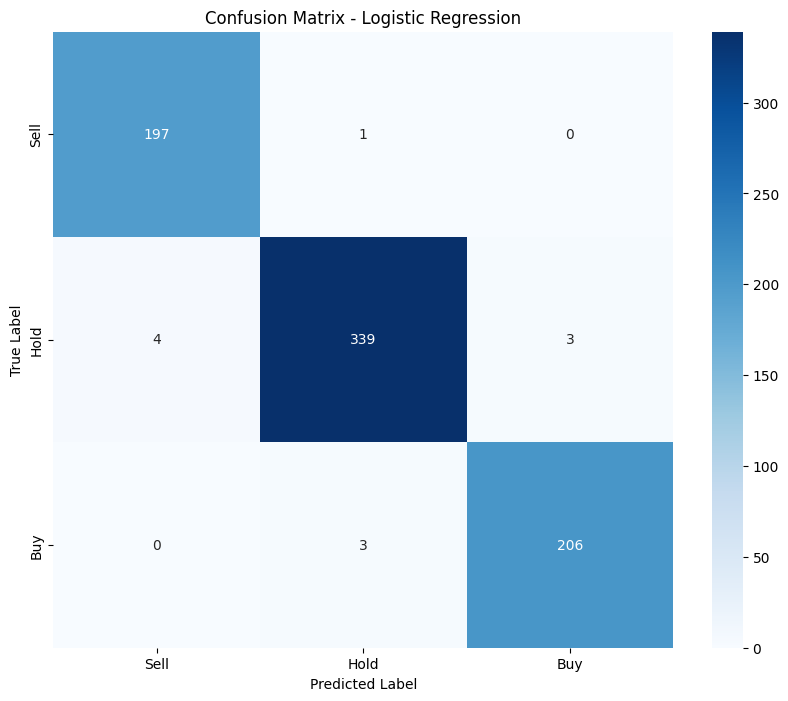


Classification Report - Logistic Regression
              precision    recall  f1-score   support

        Sell       0.98      0.99      0.99       198
        Hold       0.99      0.98      0.98       346
         Buy       0.99      0.99      0.99       209

    accuracy                           0.99       753
   macro avg       0.98      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753


Top 10 important features (Logistic Regression):
          feature  importance
10  future_return    8.440151
2           EMA50    0.310319
8            High    0.244662
9             Low    0.110926
1           EMA10    0.091495
0             RSI    0.078297
5       MACD_Hist    0.066441
7           Close    0.065728
4     MACD_Signal    0.053068
3            MACD    0.049311


In [5]:
# Train and evaluate Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate
print("\nLogistic Regression Results:")
lr_metrics = evaluate_model(y_test, lr_pred, "Logistic Regression")
model_results['Logistic Regression'] = lr_metrics

# Feature importance for Logistic Regression
lr_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.mean(np.abs(lr_model.coef_), axis=0)
})
lr_importance = lr_importance.sort_values('importance', ascending=False)

print("\nTop 10 important features (Logistic Regression):")
print(lr_importance.head(10))



Training Random Forest...

Random Forest Results:


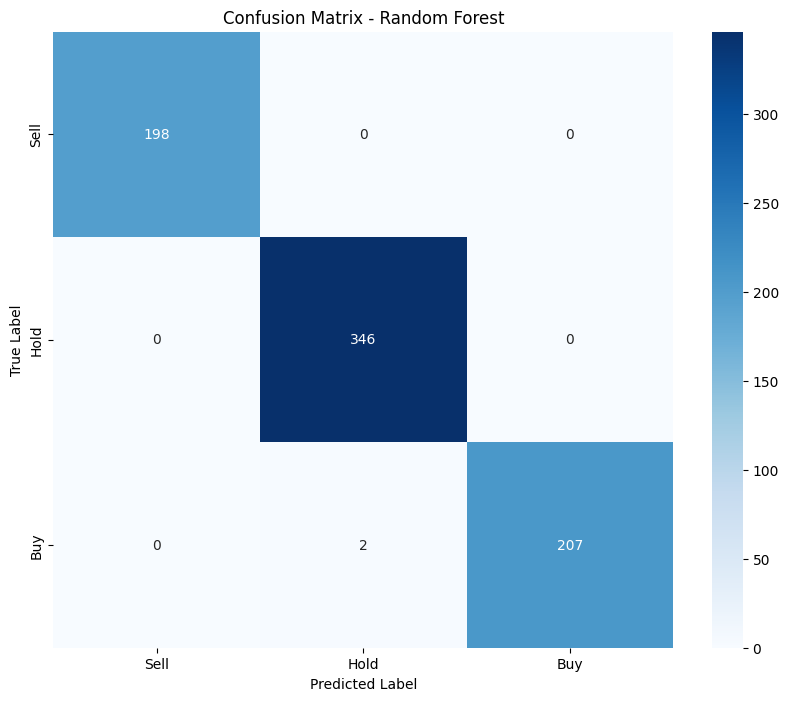


Classification Report - Random Forest
              precision    recall  f1-score   support

        Sell       1.00      1.00      1.00       198
        Hold       0.99      1.00      1.00       346
         Buy       1.00      0.99      1.00       209

    accuracy                           1.00       753
   macro avg       1.00      1.00      1.00       753
weighted avg       1.00      1.00      1.00       753


Top 10 important features (Random Forest):
          feature  importance
10  future_return    0.819563
11       HL_Range    0.028183
6          Volume    0.023041
0             RSI    0.016833
4     MACD_Signal    0.015449
3            MACD    0.014175
13   Price_1d_chg    0.013909
5       MACD_Hist    0.013134
12  Volume_1d_chg    0.011908
2           EMA50    0.009319


In [6]:
# Train and evaluate Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate
print("\nRandom Forest Results:")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
model_results['Random Forest'] = rf_metrics

# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('importance', ascending=False)

print("\nTop 10 important features (Random Forest):")
print(rf_importance.head(10))
